<a href="https://colab.research.google.com/github/hagabbar/craft_prospect/blob/master/LSTM_classification_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Networks for QRNG Quality Assurance

This is a script which will check for non-random subsequences 
from a quantum random number generator onboard a CubeSat. 
The code will first perform a benchmark suite of tests known 
as Diehard tests. The code will then use the results from these 
tests in order to benchmark results from a  
neural network approach (LSTMs).

## Import required software packages

In [3]:
%matplotlib inline
# Magic command to use the inline backend for plotting
import numpy as np
from keras import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
from scipy import signal, interpolate, special
import subprocess
from sklearn import metrics
import os
from keras.models import load_model


## Define important global variables

Here we define important global variables which will be used 
through out the rest of the ipython notebook script. The first 
section describes variables which are pertinant to the 
model training/testing sections, whereas the second section 
determines plotting variables.

In [4]:
# Model variables
tot_num_samples = 500000 # total number of training samples (50/50 split between rand and non-rand)
train_split = int(int(tot_num_samples/2) * 0.9) # use 90% for training, 10% for validation
test_set_N = 500     # number of samples in test set
test_set_size = 128
bitstream_len = 128     # length of observation window of network
batch_size = 64         # batch size (how many samples NN sees during each iteration)
bit_max_number = 4294967295
snr = 0.06             # signal to noise ratio of injected signal
np.random.seed(42)
ML_path = './results_files' # path to results data files
run = '1'              # unique name of run
use_signals = ['sineGauss','sinewave','squarewave']

# Plotting variables
snrs = [0.02, 0.04, 0.06, 0.08, 0.1] # SNRs to plot for ROC curves
runs = [1,1,1,1,1]           # runs to plot for ROC curves
thresholds = [0.1,0.01,0.001] # false alarm probabilities to compute ROC curves at
to_plot = [0,1,2,3]      # choose snrs to plot for TAP and FAP plot

## Make train/test sets

In [5]:
# Generate a set of pseudo random numbers for validation and training sets
pseudo_rand_data_train = np.random.randint(low=0,high=bit_max_number,size=(train_split,bitstream_len),dtype=np.uint32)
pseudo_rand_data_val = np.random.randint(low=0,high=bit_max_number,size=(int(tot_num_samples/2) - train_split,bitstream_len),dtype=np.uint32)
pseudo_rand_labels_train = np.ones(train_split)
pseudo_rand_labels_val = np.ones(int(tot_num_samples/2) - train_split)

# Generate pseudo random numbers test set. Need at least 10 million elements in t-series
pseudo_rand_data_test = np.random.randint(low=0,high=bit_max_number,size=(test_set_N,test_set_size),dtype=np.uint32)
pseudo_rand_labels_test = np.ones(int(test_set_N))

# Inject sinewave noise signal into pseudo random number sequences
# Generate sinewave
time = np.arange(0,bitstream_len,1)
sinewave = (np.sin(time) + 1)

# Generate sine-Gaussian [returns real (sineGauss), imaginary (q), envelope of signal (e)]
time = np.linspace(-1, 1, bitstream_len, endpoint=False)
sineGauss, q, e = signal.gausspulse(time, fc=5.0, retquad=True, retenv=True)

# Generate square wave mimicking burst-like signal
time = np.linspace(0, 1, bitstream_len, endpoint=False)
squarewave = signal.square(2 * np.pi * 5 * time)

# Make training set
# Add sinewave to noise at predefined 'snr'
sinewave_data_train = ((sinewave - np.min(sinewave)) / (np.max(sinewave)-np.min(sinewave))) + np.random.uniform(low=0,high=(1.0/snr),size=(int(train_split/3.0),bitstream_len))
sineGauss_data_train = ((sineGauss - np.min(sineGauss)) / (np.max(sineGauss)-np.min(sineGauss))) + np.random.uniform(low=0,high=(1.0/snr),size=(int(train_split/3.0),bitstream_len))
squarewave_data_train = ((squarewave - np.min(squarewave)) / (np.max(squarewave)-np.min(squarewave))) + np.random.uniform(low=0,high=(1.0/snr),size=(int(train_split/3.0),bitstream_len))
noise_data_train = np.concatenate((sinewave_data_train,sineGauss_data_train,squarewave_data_train))

# Make noisefree training set 
sinewave_noisefree_data_train = ((sinewave - np.min(sinewave)) / (np.max(sinewave)-np.min(sinewave))) + np.zeros((int(train_split/3.0),bitstream_len))
sineGauss_noisefree_data_train = ((sineGauss - np.min(sineGauss)) / (np.max(sineGauss)-np.min(sineGauss))) + np.zeros((int(train_split/3.0),bitstream_len))
squarewave_noisefree_data_train = ((squarewave - np.min(squarewave)) / (np.max(squarewave)-np.min(squarewave))) + np.zeros((int(train_split/3.0),bitstream_len))
noisefree_data_train = np.concatenate((sinewave_noisefree_data_train,sineGauss_noisefree_data_train,squarewave_noisefree_data_train))

# Normalize signal to be between zero and 1
normalization_factor = np.float32(np.max(noise_data_train))
noise_data_train = np.float32(noise_data_train) / normalization_factor
noisefree_data_train = np.float32(noisefree_data_train) / normalization_factor
# Bring signal back up to max value
noise_data_train *= bit_max_number
noisefree_data_train *= bit_max_number
# Make signal values be 32-bit integers
noise_data_train = np.uint32(noise_data_train)
#noisefree_data_train = np.uint32(noisefree_data_train)

# Make validation set
# Repeat same steps as done in training section
#noise_data_test = (sinewave / np.max(sinewave)) + np.random.uniform(low=0,high=(1.0/snr),size=(int(tot_num_samples/2) - train_split,bitstream_len))
sinewave_data_val = ((sinewave - np.min(sinewave)) / (np.max(sinewave)-np.min(sinewave))) + np.random.uniform(low=0,high=(1.0/snr),size=(int((int(tot_num_samples/2) - train_split)/3.0),bitstream_len))
sineGauss_data_val = ((sineGauss - np.min(sineGauss)) / (np.max(sineGauss)-np.min(sineGauss))) + np.random.uniform(low=0,high=(1.0/snr),size=(int((int(tot_num_samples/2) - train_split)/3.0),bitstream_len))
squarewave_data_val = ((squarewave - np.min(squarewave)) / (np.max(squarewave)-np.min(squarewave))) + np.random.uniform(low=0,high=(1.0/snr),size=(int((int(tot_num_samples/2) - train_split)/3.0),bitstream_len))
noise_data_val = np.concatenate((sinewave_data_val,sineGauss_data_val,squarewave_data_val))

noise_data_val = np.float32(noise_data_val) / np.float32(np.max(noise_data_val))
noise_data_val *= bit_max_number
noise_data_val = np.uint32(noise_data_val)

# Inject longer signals into testing set data stream
# Generate sinewave
time = np.arange(0,test_set_size,1)
sinewave = (np.sin(time) + 1)

# Generate sine-Gaussian [returns real (sineGauss), imaginary (q), envelope of signal (e)]
time = np.linspace(-1, 1, test_set_size, endpoint=False)
sineGauss, q, e = signal.gausspulse(time, fc=5.0, retquad=True, retenv=True)

# Generate square wave mimicking burst-like signal
time = np.linspace(0, 1, test_set_size, endpoint=False)
squarewave = signal.square(2 * np.pi * 5 * time)

# Make test set
sinewave_data_test = ((sinewave - np.min(sinewave)) / (np.max(sinewave)-np.min(sinewave))) + np.random.uniform(low=0,high=(1.0/snr),size=(int(test_set_N/3.0),test_set_size))
sineGauss_data_test = ((sineGauss - np.min(sineGauss)) / (np.max(sineGauss)-np.min(sineGauss))) + np.random.uniform(low=0,high=(1.0/snr),size=(int(test_set_N/3.0),test_set_size))
squarewave_data_test = ((squarewave - np.min(squarewave)) / (np.max(squarewave)-np.min(squarewave))) + np.random.uniform(low=0,high=(1.0/snr),size=(int(test_set_N/3.0),test_set_size))
noise_data_test = np.concatenate((sinewave_data_test,sineGauss_data_test,squarewave_data_test))

noise_data_test = np.float32(noise_data_test) / np.float32(np.max(noise_data_test))
noise_data_test *= bit_max_number
noise_data_test = np.uint32(noise_data_test)

# Make training, validation and test labels for signal + noise samples
noise_labels_train = np.zeros(len(noise_data_train))
noise_labels_val = np.zeros(len(noise_data_val))
noise_labels_test = np.zeros(len(noise_data_test))

# Combine all data and labels into two arrays (X and Y respectively)
X_train = np.concatenate((pseudo_rand_data_train,noise_data_train))
X_train_noisefree = np.concatenate((pseudo_rand_data_train,noisefree_data_train))
X_train_noisefree = X_train_noisefree.reshape(X_train_noisefree.shape[0],X_train_noisefree.shape[1],1)/bit_max_number
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)/bit_max_number
X_val = np.concatenate((pseudo_rand_data_val,noise_data_val))
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],1)/bit_max_number
X_test = np.concatenate((pseudo_rand_data_test,noise_data_test))
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)


Y_train = np.concatenate((pseudo_rand_labels_train,noise_labels_train))
Y_val = np.concatenate((pseudo_rand_labels_val,noise_labels_val))
Y_test = np.concatenate((pseudo_rand_labels_test,noise_labels_test))

# Randomly shuffle training sets
idx_shuffle = np.random.permutation(int(train_split*2))
X_train = X_train[idx_shuffle,:]
X_train_noisefree = X_train_noisefree[idx_shuffle,:]
Y_train = Y_train[idx_shuffle]

# Randomly shuffle testing sets
idx_shuffle = np.random.permutation((test_set_N*2)-2)
X_test = X_test[idx_shuffle,:,:]
Y_test = Y_test[idx_shuffle]

# Save test sets for later use in results plots
if os.path.exists('{0}'.format('test_sets')):
    print('{0} already exists.'.format('test_sets'))
else:
    os.mkdir('{0}'.format('test_sets'))
if os.path.exists('{0}/SNR{1}'.format('test_sets',snr)):
    print('{0}/SNR{1} already exists'.format('test_sets',snr))
else:
    os.mkdir('{0}/SNR{1}'.format('test_sets',snr))
if os.path.exists('{0}/SNR{1}/run{2}'.format('test_sets',snr,run)):
    print('{0}/SNR{1}/run{2} already exists'.format('test_sets',snr,run))
else:
    os.mkdir('{0}/SNR{1}/run{2}'.format('test_sets',snr,run))
    
np.save('{0}/SNR{1}/run{2}/test_set_val'.format('test_sets',snr,run),X_test)
np.save('{0}/SNR{1}/run{2}/test_set_labels'.format('test_sets',snr,run),Y_test)


test_sets already exists.
test_sets/SNR0.06 already exists
test_sets/SNR0.06/run1 already exists


## Show example of noise

This is a noise-only signal


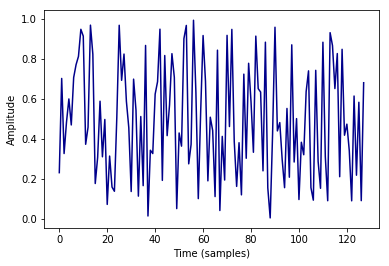

In [6]:
for i in range(X_train.shape[0]):
    if Y_train[i] == 1:
        plt.plot(X_train[i], color='darkblue') 
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        print('This is a noise-only signal')
        break

## Show example of signal + noise

This is a signal+noise signal


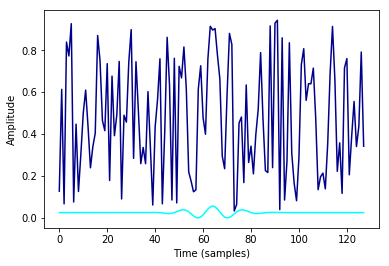

In [7]:
plt.close()
cnt = 0
for i in range(X_train.shape[0]):
    if Y_train[i] == 0:
        if cnt == 7:
            plt.plot(X_train[i], color='darkblue')
            plt.plot(X_train_noisefree[i], color='cyan')
            plt.xlabel('Time (samples)')
            plt.ylabel('Amplitude')
            print('This is a signal+noise signal')
            break
        cnt+=1

# Apply Diehard Statistical Tests

Run Diehard tests on ~10 test samples, each with 
~1e7 elements in them. We can then test our machine learning model using just 100 elements from each one of those signals (not sure whether or not this is a reasonable/fair comparison yet).

In [111]:
# Make diehard and ml results directories if they doesn't exist already
if os.path.exists('diehard_results'):
    print('diehard_results dir already exits.')
else:
    os.mkdir('diehard_results')
if os.path.exists('diehard_results/snr%.2f' % snr):
    print('diehard_results/snr%.2f already exists.' % snr)
else:
    os.mkdir('diehard_results/snr%.2f' % snr)
if os.path.exists('{0}'.format(ML_path)):
    print('{0} already exists.'.format(ML_path))
else:
    os.mkdir('{0}'.format(ML_path))
if os.path.exists('{0}/SNR{1}'.format(ML_path,snr)):
    print('{0}/SNR{1} already exists'.format(ML_path,snr))
else:
    os.mkdir('{0}/SNR{1}'.format(ML_path,snr))
if os.path.exists('{0}/SNR{1}/run{2}'.format(ML_path,snr,run)):
    print('{0}/SNR{1}/run{2} already exists'.format(ML_path,snr,run))
else:
    os.mkdir('{0}/SNR{1}/run{2}'.format(ML_path,snr,run))

diehard_results dir already exits.
diehard_results/snr0.10 already exists.
./results_files already exists.
./results_files/SNR0.1 already exists
./results_files/SNR0.1/run1 already exists


In [22]:
# Iterate over a predefined number of test samples
for j in range(len(snrs)):
    for i in range(X_test.shape[0]):
    
        # If sample is noise-alone
        if Y_test[i] == 1:
            diehard_test_sample = np.random.randint(low=0,high=bit_max_number,size=int(5e6),dtype=np.uint32)
        
        # If sample is signal + noise
        elif Y_test[i] == 0:
            signal_choice = np.random.choice(use_signals)
            if signal_choice == 'sineGauss':
                time = np.linspace(-1, 1, int(5e6), endpoint=False)
                sineGauss, q, e = signal.gausspulse(time, fc=5.0, retquad=True, retenv=True)
                diehard_test_sample = sineGauss
            elif signal_choice == 'sinewave':
                time = np.arange(0,int(5e6),1)
                sinewave = (np.sin(time) + 1)
                diehard_test_sample = sinewave
            elif signal_choice == 'squarewave':
                time = np.linspace(0, 1, int(5e6), endpoint=False)
                squarewave = signal.square(2 * np.pi * 5 * time)
                diehard_test_sample = squarewave
            diehard_test_sample = ((diehard_test_sample - np.min(diehard_test_sample)) / (np.max(diehard_test_sample)-np.min(diehard_test_sample))) + np.random.uniform(low=0,high=(1.0/snrs[j]),size=(int(5e6)))
            diehard_test_sample = np.float32(diehard_test_sample) / np.float32(np.max(diehard_test_sample))
            diehard_test_sample *= bit_max_number
            diehard_test_sample = np.uint32(diehard_test_sample)
    
        # Save test sample to binary file format
        np.save('diehard_results/snr%.2f/test_sample%d' % (snrs[j],i), diehard_test_sample)
    
        # Run diehard tests on sample
        # Can specify to do all tests using -a option
        results_file_name = 'diehard_results/snr%.2f/test_sample%d.txt' % (snrs[j],i)
        diehard_input_file = 'diehard_results/snr%.2f/test_sample%d.npy' % (snrs[j],i)
        !dieharder -g 201 -d 0 -f $diehard_input_file > $results_file_name
        print('Completed Diehard tests on sample %d with snr %.2f' % (i+1,snrs[j]))
    
        # remove saved test sample file
        os.remove(diehard_input_file)

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 1 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 2 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 3 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 4 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 5 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 6 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 7 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 8 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 9 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 10 with snr 0.02
# The file file_input_raw was rewound 2

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 86 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 87 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 88 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 89 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 90 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 91 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 92 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 93 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 94 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 95 with snr 0.02
# The file file_input_raw was 

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 170 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 171 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 172 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 173 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 174 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 175 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 176 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 177 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 178 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 179 with snr 0.02
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 254 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 255 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 256 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 257 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 258 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 259 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 260 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 261 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 262 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 263 with snr 0.02
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 338 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 339 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 340 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 341 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 342 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 343 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 344 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 345 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 346 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 347 with snr 0.02
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 422 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 423 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 424 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 425 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 426 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 427 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 428 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 429 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 430 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 431 with snr 0.02
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 506 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 507 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 508 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 509 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 510 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 511 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 512 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 513 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 514 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 515 with snr 0.02
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 590 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 591 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 592 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 593 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 594 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 595 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 596 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 597 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 598 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 599 with snr 0.02
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 674 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 675 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 676 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 677 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 678 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 679 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 680 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 681 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 682 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 683 with snr 0.02
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 758 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 759 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 760 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 761 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 762 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 763 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 764 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 765 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 766 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 767 with snr 0.02
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 842 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 843 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 844 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 845 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 846 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 847 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 848 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 849 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 850 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 851 with snr 0.02
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 926 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 927 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 928 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 929 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 930 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 931 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 932 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 933 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 934 with snr 0.02
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 935 with snr 0.02
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 12 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 13 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 14 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 15 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 16 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 17 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 18 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 19 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 20 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 21 with snr 0.04
# The file file_input_raw was 

Completed Diehard tests on sample 96 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 97 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 98 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 99 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 100 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 101 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 102 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 103 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 104 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 105 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests 

Completed Diehard tests on sample 180 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 181 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 182 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 183 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 184 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 185 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 186 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 187 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 188 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 189 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard te

Completed Diehard tests on sample 264 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 265 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 266 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 267 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 268 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 269 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 270 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 271 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 272 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 273 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard te

Completed Diehard tests on sample 348 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 349 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 350 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 351 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 352 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 353 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 354 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 355 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 356 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 357 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard te

Completed Diehard tests on sample 432 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 433 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 434 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 435 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 436 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 437 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 438 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 439 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 440 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 441 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard te

Completed Diehard tests on sample 516 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 517 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 518 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 519 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 520 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 521 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 522 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 523 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 524 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 525 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard te

Completed Diehard tests on sample 600 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 601 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 602 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 603 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 604 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 605 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 606 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 607 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 608 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 609 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard te

Completed Diehard tests on sample 684 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 685 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 686 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 687 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 688 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 689 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 690 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 691 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 692 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 693 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard te

Completed Diehard tests on sample 768 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 769 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 770 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 771 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 772 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 773 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 774 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 775 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 776 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 777 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard te

Completed Diehard tests on sample 852 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 853 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 854 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 855 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 856 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 857 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 858 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 859 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 860 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 861 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard te

Completed Diehard tests on sample 936 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 937 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 938 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 939 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 940 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 941 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 942 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 943 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 944 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 945 with snr 0.04
# The file file_input_raw was rewound 2 times
Completed Diehard te

Completed Diehard tests on sample 22 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 23 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 24 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 25 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 26 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 27 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 28 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 29 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 30 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 31 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sam

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 107 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 108 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 109 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 110 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 111 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 112 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 113 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 114 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 115 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 116 with snr 0.06
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 191 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 192 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 193 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 194 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 195 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 196 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 197 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 198 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 199 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 200 with snr 0.06
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 275 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 276 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 277 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 278 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 279 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 280 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 281 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 282 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 283 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 284 with snr 0.06
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 359 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 360 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 361 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 362 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 363 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 364 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 365 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 366 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 367 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 368 with snr 0.06
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 443 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 444 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 445 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 446 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 447 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 448 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 449 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 450 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 451 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 452 with snr 0.06
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 527 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 528 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 529 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 530 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 531 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 532 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 533 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 534 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 535 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 536 with snr 0.06
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 611 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 612 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 613 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 614 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 615 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 616 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 617 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 618 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 619 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 620 with snr 0.06
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 695 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 696 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 697 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 698 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 699 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 700 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 701 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 702 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 703 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 704 with snr 0.06
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 779 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 780 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 781 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 782 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 783 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 784 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 785 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 786 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 787 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 788 with snr 0.06
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 863 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 864 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 865 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 866 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 867 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 868 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 869 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 870 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 871 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 872 with snr 0.06
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 947 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 948 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 949 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 950 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 951 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 952 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 953 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 954 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 955 with snr 0.06
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 956 with snr 0.06
# The file file_inpu

Completed Diehard tests on sample 33 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 34 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 35 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 36 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 37 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 38 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 39 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 40 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 41 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 42 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sam

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 118 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 119 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 120 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 121 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 122 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 123 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 124 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 125 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 126 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 127 with snr 0.08
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 202 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 203 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 204 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 205 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 206 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 207 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 208 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 209 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 210 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 211 with snr 0.08
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 286 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 287 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 288 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 289 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 290 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 291 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 292 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 293 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 294 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 295 with snr 0.08
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 370 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 371 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 372 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 373 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 374 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 375 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 376 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 377 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 378 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 379 with snr 0.08
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 454 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 455 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 456 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 457 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 458 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 459 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 460 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 461 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 462 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 463 with snr 0.08
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 538 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 539 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 540 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 541 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 542 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 543 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 544 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 545 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 546 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 547 with snr 0.08
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 622 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 623 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 624 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 625 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 626 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 627 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 628 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 629 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 630 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 631 with snr 0.08
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 706 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 707 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 708 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 709 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 710 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 711 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 712 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 713 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 714 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 715 with snr 0.08
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 790 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 791 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 792 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 793 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 794 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 795 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 796 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 797 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 798 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 799 with snr 0.08
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 874 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 875 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 876 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 877 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 878 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 879 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 880 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 881 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 882 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 883 with snr 0.08
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 958 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 959 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 960 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 961 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 962 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 963 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 964 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 965 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 966 with snr 0.08
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 967 with snr 0.08
# The file file_inpu

Completed Diehard tests on sample 44 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 45 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 46 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 47 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 48 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 49 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 50 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 51 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 52 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 53 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sam

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 129 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 130 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 131 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 132 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 133 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 134 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 135 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 136 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 137 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 138 with snr 0.10
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 213 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 214 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 215 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 216 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 217 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 218 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 219 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 220 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 221 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 222 with snr 0.10
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 297 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 298 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 299 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 300 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 301 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 302 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 303 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 304 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 305 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 306 with snr 0.10
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 381 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 382 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 383 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 384 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 385 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 386 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 387 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 388 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 389 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 390 with snr 0.10
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 465 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 466 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 467 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 468 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 469 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 470 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 471 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 472 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 473 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 474 with snr 0.10
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 549 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 550 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 551 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 552 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 553 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 554 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 555 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 556 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 557 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 558 with snr 0.10
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 633 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 634 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 635 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 636 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 637 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 638 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 639 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 640 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 641 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 642 with snr 0.10
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 717 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 718 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 719 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 720 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 721 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 722 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 723 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 724 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 725 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 726 with snr 0.10
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 801 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 802 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 803 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 804 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 805 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 806 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 807 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 808 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 809 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 810 with snr 0.10
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 885 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 886 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 887 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 888 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 889 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 890 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 891 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 892 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 893 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 894 with snr 0.10
# The file file_inpu

# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 969 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 970 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 971 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 972 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 973 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 974 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 975 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 976 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 977 with snr 0.10
# The file file_input_raw was rewound 2 times
Completed Diehard tests on sample 978 with snr 0.10
# The file file_inpu

In [88]:
for j in range(len(snrs)):
    # Define array to store Diehard results in
    # Size of array is (n_test_samples,num_diehard_tests)
    diehard_results = np.zeros((X_test.shape[0],1))

    """
    Store results of Diehard tests in file
    """
    # Iterate over all test samples
    for i in range(X_test.shape[0]):

        # Save results for one test sample to total array
        test = open('diehard_results/snr%.2f/test_sample%d.txt' % (snrs[j],i), 'r+')
        t1 = test.readlines()
        line_cnt = 0
        test_cnt = 0
        for t1_line in t1:
            line_cnt +=1
            if line_cnt <= 8:
                continue
            if line_cnt > 8:
                if t1_line.split()[-1] == 'PASSED':
                    result_ele = 1.0
                elif t1_line.split()[-1] == 'FAILED':
                    result_ele = 0.0
                elif t1_line.split()[-1] == 'WEAK':
                    result_ele = 0.5
                diehard_results[i,test_cnt] = result_ele
                test_cnt += 1
        
    # Save all Diehard results to one file
    np.save('{0}/SNR{1}/run{2}/diehard_preds.npy'.format(ML_path,snrs[j],run), diehard_results)
    np.save('{0}/SNR{1}/run{2}/diehard_targets.npy'.format(ML_path,snrs[j],run), Y_test)

# Train and Test ML Model

## Option to load network model

In [26]:
model = load_model('trained_model/model.h5')

## Define network model

In [8]:
# Define network hyperparameters
lstm_out = 100
batch_size = 64

model = Sequential()


# CNN-LSTM network
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(LSTM(lstm_out))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))


"""
# Simple fully-connected network
model.add(Dense(128, input_dim=bitstream_len, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
"""


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#print(model.summary())

## Train and save model

In [ ]:
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size = batch_size, epochs = 100,  verbose = 1)

Train on 450000 samples, validate on 49999 samples
Epoch 1/100
262016/450000 [================>.............] - ETA: 47s - loss: 0.3388 - acc: 0.8455

In [205]:
model.save('trained_model/model.h5')

## Evaluate model

Evaluate the accuracy on a unique test set which has 
not been used during either the training or the validation phase. 
Only look at the first N elements of sequences (same length as that 
used during training).

In [214]:
score,acc = model.evaluate(X_test[:,:bitstream_len]/bit_max_number,Y_test,batch_size=batch_size,verbose=2)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

Score: 0.39
Validation Accuracy: 0.81


In [215]:
# Make predictions
preds = model.predict(X_test[:,:bitstream_len]/bit_max_number)
targets = Y_test[:]

# Save model predictions
np.save('{0}/SNR{1}/run{2}/targets.npy'.format(ML_path,snr,run), targets)
np.save('{0}/SNR{1}/run{2}/preds.npy'.format(ML_path,snr,run), preds)

## Results plots

Plots illustrating the robustness of the model.

In [187]:
def CNN_ROC(ml_path, snr, run, network_type, num_test):
    """
    calculate roc curve for machine learning results
    """
    if network_type == 'ML':
        targets = np.load('{0}/SNR{1}/run{2}/targets.npy'.format(ml_path,snr,run))
        preds = np.load('{0}/SNR{1}/run{2}/preds.npy'.format(ml_path,snr,run))
    elif network_type == 'diehard':
        targets = np.load('{0}/SNR{1}/run{2}/diehard_targets.npy'.format(ml_path,snr,run))
        preds = np.load('{0}/SNR{1}/run{2}/diehard_preds.npy'.format(ml_path,snr,run))
    targets, preds = targets[:num_test], preds[:num_test,:]
    assert len(preds) == len(targets)
    FDP, TDP, _ = metrics.roc_curve(targets, preds)
    FDP_error = [sigma(len(targets)/2., t) for t in FDP]
    TDP_error = [sigma(len(targets)/2., t) for t in TDP]
    return FDP, TDP, FDP_error, TDP_error

In [67]:
def sigma(n, tp):
    """ Computes standard deviation
    :param tp:
    :param n:
    :return:
    """
    return np.sqrt(tp*(1.-tp)/n)

In [68]:
def accuracy(FDP,TDP,TDP_error, threshold):
    """
    calculate accuracy(efficiency) given fdp and tdp
    """
    fx = interpolate.interp1d(FDP,TDP)
    fx_e_neg = interpolate.interp1d(FDP,TDP-TDP_error)
    fx_e_pos = interpolate.interp1d(FDP,TDP+TDP_error)
    acc = fx(threshold)
    acc_e_neg = fx_e_neg(threshold)
    acc_e_pos = fx_e_pos(threshold)
    return acc, acc_e_neg, acc_e_pos

In [69]:
def interp_sig(snr, tdp, threshold, c, snrs):
    """
    use spline interpolation to fit a line
    uses sigmoid to map (0,1) to (-inf, inf) and vice-versa
    :param snr:
    :param rho:
    :param threshold:
    :param snrs: list of snrs
    :return:
    """
    # assume start with NaN
    flag = True
    while flag:
        snr_new, tdp_new = interp_loop(snr, tdp, threshold, c, snrs)
        if not np.isnan(tdp_new).any():
            flag = False
        else:
            snr = snr[1:]
            tdp = tdp[1:]

    if np.isnan(tdp_new).any():
        print('Failed to avoid NaNs')

    return snr_new, tdp_new

In [70]:
def interp_loop(snr, tdp, threshold, c, snrs):
    """
    function to loop over to peform spline interpolation
    :param snr:
    :param rho:
    :param threshold:
    :param c: fuzzfactor
    :param snrs: list of snr values
    """
    # find min value
    min_tdp = np.min(tdp)
    # take log of data to avoid negative values
    tmp_tdp = special.logit(tdp - min_tdp + c)
    # interpolate with spline interpolation
    tck = interpolate.splrep(snr, tmp_tdp)
    # new x and y values
    snr_new = np.linspace(snrs[0], snrs[-1], 1e3)
    tmp_tdp_new = interpolate.splev(snr_new, tck, der=0)
    # return to linear space
    tdp_new = special.expit(tmp_tdp_new) + min_tdp - c

    return snr_new, tdp_new

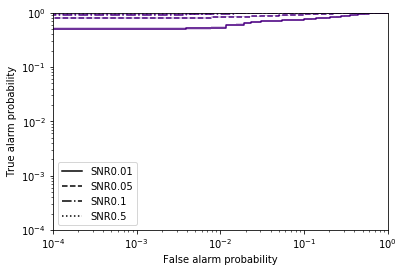

In [216]:
# Make TAP/FAP figure

# empty lists to populate
MF_ROCs = []
CNN_ROCs = []
MF_acc = []
CNN_acc = []

# plot roc curves
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
ax1.set_rasterization_zorder(1)

# colours and line styles for plots
colours = ['indigo', 'c', 'darkorange', 'indigo', 'c', 'darkorange', 'indigo', 'c', 'darkorange']
linestyles = ['-', '--', '-.', ':']

lineArtist = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-')
dashArtist = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--')
dashdotArtist = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-.')
dotArtist = plt.Line2D((0,1), (0, 0), color = 'k', linestyle = ':')
c1Artist = plt.Line2D((0, 1), (0, 0), color=colours[0], linestyle='', marker='o')
c2Artist = plt.Line2D((0, 1), (0, 0), color=colours[1], linestyle='', marker='o')
c3Artist = plt.Line2D((0, 1), (0, 0), color=colours[2], linestyle='', marker='o')

# handles for different plots
handles = [lineArtist, dashArtist, dashdotArtist,dotArtist]
acc_handles = [c1Artist, c2Artist, lineArtist, dashArtist, dashdotArtist]
ROC_labels = ['SNR0.01', 'SNR0.05', 'SNR0.1', 'SNR0.5']
acc_labels = ['CNN-LSTM', 'Diehard', 'FAP = 0.1', 'FAP = 0.01', 'FAP = 0.001']

# calcualte ROC curves and accuracy
for snr, run in zip(snrs, runs):
    FDP, TDP, FDP_error, TDP_error = CNN_ROC(ML_path, snr, run, 'ML', test_set_N)
    CNN_ROCs.append([FDP, TDP, FDP_error, TDP_error])
    CNN_acc.append([accuracy(FDP, TDP, TDP_error, t) for t in thresholds])
    
    FDP, TDP, FDP_error, TDP_error = CNN_ROC(ML_path, snr, run, 'diehard', test_set_N)
    MF_ROCs.append([FDP, TDP, FDP_error, TDP_error])
    MF_acc.append([accuracy(FDP, TDP, TDP_error, t) for t in thresholds])

for i, d in enumerate([CNN_ROCs[n] for n in to_plot]):
    ax1.plot(d[0], d[1], c=colours[0], linestyle=linestyles[i], label='CNN snr {0}'.format(snrs[i]))
    ax1.fill_between(d[0], d[1]+d[3], d[1]-d[3], alpha=0.2, facecolor=colours[0], zorder=0)
    
ax1.set_xlabel('False alarm probability')
ax1.set_ylabel('True alarm probability')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-4, 1)
ax1.set_ylim(1e-4, 1)
ax1.legend(handles, ROC_labels)

In [217]:
preds = np.load('{0}/SNR{1}/run{2}/preds.npy'.format(ML_path,0.02,run))
targets = np.load('{0}/SNR{1}/run{2}/targets.npy'.format(ML_path,0.02,run))
cnt = 0
for i in range(preds.shape[0]):
    if preds[i] == targets[i]:
        cnt+=1

/home/hunter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/hunter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


(0, 1)

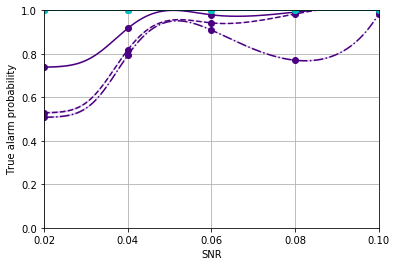

In [218]:
# Make efficiency curve
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1, )
ax2.set_rasterization_zorder(1)

# fuzz factors for each thresholds
ffs = [0.5e-3, 0.5e-3, 0.5e-3]

for i in range(len(thresholds)):
    # points to plot
    cnn = np.asarray([a[i][0] for a in CNN_acc])
    # line fit
    snr_cnn, eff_cnn = interp_sig(snrs, cnn, thresholds[i], ffs[i], snrs)
    
    # points to plot
    mf = np.asarray([a[i][0] for a in MF_acc])
    # line fit
    snr_mf, eff_mf = interp_sig(snrs, mf, thresholds[i], ffs[1], snrs)

    # errors
    d_eff_cnn = [sigma(1e4, e) for e in eff_cnn]
    d_eff_mf = [sigma(1e4, e) for e in eff_mf]

    # plot points for cnn
    ax2.plot(snrs, cnn, c=colours[0], marker = 'o', linestyle='')
    # plot line fit for cnn
    ax2.plot(snr_cnn, eff_cnn, c=colours[0], linestyle=linestyles[i])
    # plot error region for cnn
    ax2.fill_between(snr_cnn, eff_cnn - d_eff_cnn , eff_cnn + d_eff_cnn, facecolor=colours[0], alpha=0.2, zorder=0)

    
    # plot points for mf
    ax2.plot(snrs, mf, c=colours[1], marker = 'o', linestyle='')
    # plot line fit for mf
    ax2.plot(snr_mf, eff_mf, c=colours[1], linestyle=linestyles[i])
    # plot error region for mf
    ax2.fill_between(snr_mf, eff_mf - d_eff_mf, eff_mf + d_eff_mf, facecolor=colours[1], alpha=0.2, zorder=0)
    

#ax2.legend(acc_handles, acc_labels)
ax2.set_xticks(snrs)
ax2.grid()
ax2.set_xlabel('SNR')
ax2.set_ylabel('True alarm probability')
ax2.set_xlim(snrs[0], snrs[-1])
ax2.set_ylim(0, 1)